# Hyperparameter tuning

A linear combination of centrality degree, closeness, betwenness and eigenvector is hypertuned by using `optuna` to reduce the number of dead people after equilibrium is achieved. Each set of parameters is averaged over 20 runs with different random seeds. 

In [93]:
import pandas as pd
from experiment import concert_prob_per_day
import json
import networkx as nx
import random
from tqdm import tqdm
from simulation import simulate_epidemic
import optuna
import numpy as np
import matplotlib.pyplot as plt

attendence_prob = {
    #(id1 likes, id2 likes)
    (True, True): 0.393,
    (True, False): 0.018,
    (False, True): 0.018,
    (False, False): 0.002
}

def load_friendships():
    # Load of pairs of friends
    friendships = pd.read_csv("grupee_data/friends.csv", skiprows=1, names= ["id1", "id2"])

    # Drop any entries with NaN
    friendships.dropna(inplace=True)
    return friendships

def load_preferences():
    # Get preferences
    with open('grupee_data/preferences.json') as f:
        preferences = json.load(f)

    # Create a dict with {id1: {Genre1: 0, Genre2: 1, ...},
    #                    id2: {Genre2: 0, Genre2: 1, ...},
    #                     ...
    #                       }
    preferences_dict = {}
    for id in tqdm(preferences, desc='Load Preferences', leave=False):
        temp_dict = {}
        for i, genre in enumerate(concert_prob_per_day.keys()):
            temp_dict[genre] = int(preferences[id][i])

        preferences_dict[int(id)] = temp_dict

    return preferences_dict


def build_social_graph(friendships):
    G = nx.Graph()
    for _, row in tqdm(friendships.iterrows(), desc='Build Graph', leave=False):
        G.add_edge(row['id1'], row['id2'])
    return G


def add_preferences_to_graph(G, preferences):
    for node, genres in tqdm(preferences.items(), desc='Add Preferences', leave=False):
        if node in G:
            nx.set_node_attributes(G, {node: genres}, "preferences")


def compute_centralities(G):
    # Compute various centrality measures
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    
    # Combine or analyze them separately
    return degree_centrality, betweenness_centrality, closeness_centrality

def simulate_concert_attendance(G, concert_prob, attendence_prob):
    infected_nodes = set()
    for genre, prob in tqdm(concert_prob.items(), desc='Simulation', leave=False):
        if random.random() < prob:
            # Identify attendees of this genre's concert
            attendees = [
                node for node, attrs in G.nodes(data=True)
                if attrs.get("preferences", {}).get(genre, 0) == 1
            ]
            
            # Simulate transmission among attendees based on friendship and attendance probabilities
            for node1 in attendees:
                for node2 in attendees:
                    if G.has_edge(node1, node2):
                        id1_likes = G.nodes[node1]['preferences'][genre] == 1
                        id2_likes = G.nodes[node2]['preferences'][genre] == 1
                        if random.random() < attendence_prob[(id1_likes, id2_likes)]:
                            infected_nodes.add(node2)
    return infected_nodes

def select_vaccine_candidates(G, centrality, percent=0.12):
    sorted_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
    num_to_select = int(len(G.nodes) * percent)
    return [node for node, _ in sorted_nodes[:num_to_select]]

def write_vaccine_candidates_to_file(vaccine_candidates, filename="vaccine_candidates.txt"):
    """
    Writes the list of vaccine candidate IDs to a text file, one ID per line.

    Args:
        vaccine_candidates (list): List of user IDs selected for vaccination.
        filename (str): Name of the output file. Defaults to "vaccine_candidates.txt".
    """
    try:
        with open(filename, "w") as file:
            for candidate in vaccine_candidates:
                file.write(f"{candidate}\n")
        print(f"Vaccine candidates successfully written to {filename}")
    except Exception as e:
        print(f"An error occurred while writing to the file: {e}")

In [5]:
# Load data
friendships = load_friendships()
preferences = load_preferences()

# Build graph
G = build_social_graph(friendships)
add_preferences_to_graph(G, preferences)

In [8]:
def calculate_centrality(G):
    # Compute various centrality measures
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G)

    return degree_centrality, betweenness_centrality, closeness_centrality, eigenvector_centrality

# Calculate the centrality before-hand to reduce computation time
dc, bc, cc, ec = calculate_centrality(G)

In [9]:
def compute_combined_centrality(G, weights, dc=dc, bc=bc, cc=cc, ec=ec):
    # Combine centralities linearly with weights
    combined_centrality = {}
    for node in G.nodes:
        combined_centrality[node] = (
            weights['degree'] * dc.get(node, 0) +
            weights['betweenness'] * bc.get(node, 0) +
            weights['closeness'] * cc.get(node, 0) +
            weights['eigenvector'] * ec.get(node, 0)
        )
    return combined_centrality

In [95]:
def run_simulation_with_seed(G, concert_prob_per_day, attendence_prob, vaccine_candidates, seed):
    """
    Run a single simulation with a specific random seed.
    """
    random.seed(seed)  # Set the random seed for reproducibility
    np.random.seed(seed)  # Set seed for numpy if needed
    
    # Simulate epidemic
    results = simulate_epidemic(
        G,
        vaccine_candidates,
        concert_prob_per_day,
        attendence_prob,
        days=100,
        initial_infected=93
    )
    return results

In [59]:
def optimize_vaccine_strategy(trial, G, concert_prob_per_day, attendence_prob):
    # Define hyperparameters to optimize
    weights = {
        'degree': trial.suggest_float('degree', 0, 1),
        'betweenness': trial.suggest_float('betweenness', 0, 1),
        'closeness': trial.suggest_float('closeness', 0, 1),
        'eigenvector': trial.suggest_float('eigenvector', 0, 1),
    }
    
    # Normalize weights to sum to 1
    total_weight = sum(weights.values())
    for key in weights:
        weights[key] /= total_weight

    # Compute combined centrality
    combined_centrality = compute_combined_centrality(G, weights)
    
    # Select vaccine candidates based on combined centrality
    vaccine_candidates = select_vaccine_candidates(G, combined_centrality, percent=0.12)
    
    # Generate a list of 20 random integers between 1 and 1000000
    seeds = [random.randint(1, 1000000) for _ in range(20)]
    
    # Run 20 simulations with different seeds
    all_results = []
    for seed in seeds:
        # seed = i  # Unique seed for each run
        # print(f"Running simulation {i+1} with seed {seed}...")
        results = run_simulation_with_seed(G, concert_prob_per_day, attendence_prob, vaccine_candidates, seed)
        all_results.append(results)

    # Calculate the total deaths for each run
    total_dead = [run["dead"] for run in all_results]
    
    # Calculate objective (minimize the mean of deaths over the random runs)
    mean_total_dead = np.mean(total_dead)
    return mean_total_dead  # Objective to minimize

if __name__ == '__main__':
    # Optimize weights using Optuna
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: optimize_vaccine_strategy(trial, G, concert_prob_per_day, attendence_prob), n_trials=20)

    print(f"Best Parameters: {study.best_params}")
    print(f"Best Objective Value: {study.best_value}")

[I 2024-12-09 08:11:55,240] A new study created in memory with name: no-name-c4c2da40-1351-433a-a920-7e5216d030f8
Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.49it/s]
[I 2024-12-09 08:14:49,246] Trial 0 finished with value: 181.703 and parameters: {'degree': 0.9782998633701178, 'betweenness': 0.8329292568756077, 'closeness': 0.25195759088811787, 'eigenvector': 0.6723595298456196}. Best is trial 0 with value: 181.703.
Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.02it/s]
[I 2024-12-09 08:17:57,779] Trial 1 finished with value: 188.5235 and parameters: {'degree': 0.5054506699828517, 'betweenness': 0.10417117187170422, 'closeness': 0.16819322525317926, 'eigenvector': 0.2660013253113591}. Best is trial 0 with value: 181.703.
Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.73it/s]
[I 2024-12-09 08

Best Parameters: {'degree': 0.7405067524656271, 'betweenness': 0.17456773671944492, 'closeness': 0.35812755550334613, 'eigenvector': 0.19557558263450808}
Best Objective Value: 171.4555


In [70]:
# Calculate the best centrality for the values of the second run
best_centrality_run2 = compute_combined_centrality(G, best_weights_run2)

# Vaccinate the 12% of individuals with the higher score
vaccine_candidates = select_vaccine_candidates(G, dc, percent=0.12)

# Generate a list of 20 random integers between 1 and 1000000
seeds = [random.randint(1, 1000000) for _ in range(20)]

# Run 20 simulations with different seeds
all_results_run2 = []
for i, seed in enumerate(seeds):
    print(f"Running simulation {i+1} with seed {seed}...")
    results = run_simulation_with_seed(G, concert_prob_per_day, attendence_prob, vaccine_candidates, seed)
    all_results_run2.append(results)

# Analyze results
total_deaths_run2 = [run['dead'][-1] for run in all_results_run2]
total_infections_run2 = [run['infected'][-1] for run in all_results_run2]

Running simulation 1 with seed 701690...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.68it/s]


Running simulation 2 with seed 364688...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.31it/s]


Running simulation 3 with seed 428560...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.42it/s]


Running simulation 4 with seed 750428...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.98it/s]


Running simulation 5 with seed 369894...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.85it/s]


Running simulation 6 with seed 321386...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.69it/s]


Running simulation 7 with seed 755709...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.22it/s]


Running simulation 8 with seed 704108...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.39it/s]


Running simulation 9 with seed 718920...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.41it/s]


Running simulation 10 with seed 67755...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.58it/s]


Running simulation 11 with seed 686552...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.30it/s]


Running simulation 12 with seed 798681...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.48it/s]


Running simulation 13 with seed 691995...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.13it/s]


Running simulation 14 with seed 104634...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.11it/s]


Running simulation 15 with seed 45475...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.24it/s]


Running simulation 16 with seed 235438...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.04it/s]


Running simulation 17 with seed 355194...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.71it/s]


Running simulation 18 with seed 733134...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.64it/s]


Running simulation 19 with seed 522076...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.61it/s]


Running simulation 20 with seed 168495...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.91it/s]


In [72]:
# Calculate the best centrality for the values of the first run
best_centrality_run1 = compute_combined_centrality(G, best_weights_run1)

# Vaccinate the 12% of individuals with the higher score
vaccine_candidates_run1 = select_vaccine_candidates(G, best_centrality_run1, percent=0.12)

# Generate a list of 20 random integers between 1 and 1000000
seeds = [random.randint(1, 1000000) for _ in range(20)]

# Run 20 simulations with different seeds
all_results_run1 = []
for i, seed in enumerate(seeds):
    print(f"Running simulation {i+1} with seed {seed}...")
    results = run_simulation_with_seed(G, concert_prob_per_day, attendence_prob, vaccine_candidates_run1, seed)
    all_results_run1.append(results)

# Analyze results
total_deaths_run1 = [run['dead'][-1] for run in all_results_run1]
total_infections_run1 = [run['infected'][-1] for run in all_results_run1]

Running simulation 1 with seed 70008...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.59it/s]


Running simulation 2 with seed 186727...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.30it/s]


Running simulation 3 with seed 668857...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.13it/s]


Running simulation 4 with seed 728580...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.72it/s]


Running simulation 5 with seed 78627...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.66it/s]


Running simulation 6 with seed 714262...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.68it/s]


Running simulation 7 with seed 16076...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.58it/s]


Running simulation 8 with seed 102972...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.44it/s]


Running simulation 9 with seed 965204...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.82it/s]


Running simulation 10 with seed 204258...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.08it/s]


Running simulation 11 with seed 838761...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.81it/s]


Running simulation 12 with seed 737231...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.66it/s]


Running simulation 13 with seed 17808...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.49it/s]


Running simulation 14 with seed 940718...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.27it/s]


Running simulation 15 with seed 471106...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.39it/s]


Running simulation 16 with seed 95697...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.06it/s]


Running simulation 17 with seed 921368...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  9.07it/s]


Running simulation 18 with seed 628193...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.17it/s]


Running simulation 19 with seed 566594...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.09it/s]


Running simulation 20 with seed 169730...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.18it/s]


In [73]:
# Calculate results for just using each method individually and not combined (degree of centrality)
vaccine_candidates_dc = select_vaccine_candidates(G, dc, percent=0.12)

# Generate a list of 20 random integers between 1 and 1000000
seeds = [random.randint(1, 1000000) for _ in range(20)]

# Run 20 simulations with different seeds
all_results_dc = []
for i, seed in enumerate(seeds):
    print(f"Running simulation {i+1} with seed {seed}...")
    results = run_simulation_with_seed(G, concert_prob_per_day, attendence_prob, vaccine_candidates_dc, seed)
    all_results_dc.append(results)

# Analyze results
total_deaths_dc = [run['dead'][-1] for run in all_results_dc]
total_infections_dc = [run['infected'][-1] for run in all_results_dc]

Running simulation 1 with seed 920612...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.67it/s]


Running simulation 2 with seed 522279...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.04it/s]


Running simulation 3 with seed 28191...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.06it/s]


Running simulation 4 with seed 211121...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.01it/s]


Running simulation 5 with seed 860305...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.72it/s]


Running simulation 6 with seed 672238...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.59it/s]


Running simulation 7 with seed 742863...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.30it/s]


Running simulation 8 with seed 679554...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.26it/s]


Running simulation 9 with seed 466444...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.25it/s]


Running simulation 10 with seed 961016...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.45it/s]


Running simulation 11 with seed 121329...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.03it/s]


Running simulation 12 with seed 780153...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.42it/s]


Running simulation 13 with seed 926679...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.78it/s]


Running simulation 14 with seed 337605...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.57it/s]


Running simulation 15 with seed 304462...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.95it/s]


Running simulation 16 with seed 914063...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.13it/s]


Running simulation 17 with seed 932147...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.87it/s]


Running simulation 18 with seed 645483...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.33it/s]


Running simulation 19 with seed 194184...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.21it/s]


Running simulation 20 with seed 622580...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.03it/s]


In [74]:
mean_deaths_run1 = np.mean(total_deaths_run1)
mean_deaths_run2 = np.mean(total_deaths_run2)
mean_deaths_dc = np.mean(total_deaths_dc)
mean_deaths_run1, mean_deaths_run2, mean_deaths_dc

(269.15, 265.7, 247.4)

Results are worse than the just using degree of centrality

In [76]:
# Search over 100 trials for better results
if __name__ == '__main__':
    # Optimize weights using Optuna
    study3 = optuna.create_study(direction="minimize")
    study3.optimize(lambda trial: optimize_vaccine_strategy(trial, G, concert_prob_per_day, attendence_prob), n_trials=100)

    print(f"Best Parameters: {study3.best_params}")
    print(f"Best Objective Value: {study3.best_value}")

[I 2024-12-09 11:58:39,565] A new study created in memory with name: no-name-6b1bb7a8-3571-43e2-afe0-23c17cd55d9f
Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.27it/s]
[I 2024-12-09 12:01:48,315] Trial 0 finished with value: 197.818 and parameters: {'degree': 0.6047517838334755, 'betweenness': 0.47888226193411254, 'closeness': 0.21934514606935374, 'eigenvector': 0.2420689631072972}. Best is trial 0 with value: 197.818.
Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.61it/s]
[I 2024-12-09 12:05:14,228] Trial 1 finished with value: 195.9365 and parameters: {'degree': 0.107699214921541, 'betweenness': 0.5106842277710084, 'closeness': 0.7578763161267194, 'eigenvector': 0.45186185135323387}. Best is trial 1 with value: 195.9365.
Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.97it/s]
[I 2024-12-09 12

Best Parameters: {'degree': 0.9453811635612114, 'betweenness': 0.6430584318202077, 'closeness': 0.0023328396072575318, 'eigenvector': 0.0011042107546686414}
Best Objective Value: 157.396


In [78]:
# Prepare the vaccine_candidates list
best_weights_run3 = study3.best_params
best_centrality_run3 = compute_combined_centrality(G, best_weights_run3)
vaccine_candidates_run3 = select_vaccine_candidates(G, best_centrality_run3, percent=0.12)

# Generate a list of 20 random integers between 1 and 1000000
seeds = [random.randint(1, 1000000) for _ in range(20)]

# Run 20 simulations with different seeds
all_results_run3 = []
for i, seed in enumerate(seeds):
    print(f"Running simulation {i+1} with seed {seed}...")
    results = run_simulation_with_seed(G, concert_prob_per_day, attendence_prob, vaccine_candidates_run3, seed)
    all_results_run3.append(results)

Running simulation 1 with seed 119695...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.52it/s]


Running simulation 2 with seed 467534...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.75it/s]


Running simulation 3 with seed 796782...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.21it/s]


Running simulation 4 with seed 70691...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.51it/s]


Running simulation 5 with seed 717995...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.93it/s]


Running simulation 6 with seed 657453...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.00it/s]


Running simulation 7 with seed 231855...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.34it/s]


Running simulation 8 with seed 824001...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.02it/s]


Running simulation 9 with seed 508658...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.88it/s]


Running simulation 10 with seed 458500...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.02it/s]


Running simulation 11 with seed 3941...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.03it/s]


Running simulation 12 with seed 834109...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.25it/s]


Running simulation 13 with seed 566242...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.15it/s]


Running simulation 14 with seed 549880...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.00it/s]


Running simulation 15 with seed 42935...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.93it/s]


Running simulation 16 with seed 517643...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.52it/s]


Running simulation 17 with seed 757994...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.99it/s]


Running simulation 18 with seed 290915...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.84it/s]


Running simulation 19 with seed 132810...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.06it/s]


Running simulation 20 with seed 69717...


Simulation Days: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.30it/s]


In [91]:
def avg_and_plot(data):

    # Get the individual classes
    infected = np.array([run['infected'] for run in data])
    dead = np.array([run['dead'] for run in data])
    immune = np.array([run['immune'] for run in data])

    # Calculate mean and std for the individual classes
    infected_mean = np.mean(infected, axis=0)
    infected_err = np.std(infected, axis=0)
    
    dead_mean = np.mean(dead, axis=0)
    dead_err = np.std(dead, axis=0)
    
    immune_mean = np.mean(immune, axis=0)
    immune_err = np.std(immune, axis=0)
    
    # Get the time coordinate
    t = np.linspace(0, len(infected_mean), len(infected_mean))
    
    # Plot each class with the error bars
    plt.figure(figsize=(14, 8))
    
    plt.plot(t, infected_mean, label="infected", c="orange")
    plt.errorbar(t, infected_mean, yerr=infected_err, capsize=3, fmt=" ", c="orange")
    
    plt.plot(t, dead_mean, label="dead", c="red")
    plt.errorbar(t, dead_mean, yerr=dead_err, capsize=3, fmt=" ", c="red")
    
    plt.plot(t, immune_mean, label="immune", c="blue")
    plt.errorbar(t, immune_mean, yerr=immune_err, capsize=3, fmt=" ", c="blue")
    
    
    plt.legend()
    plt.show()

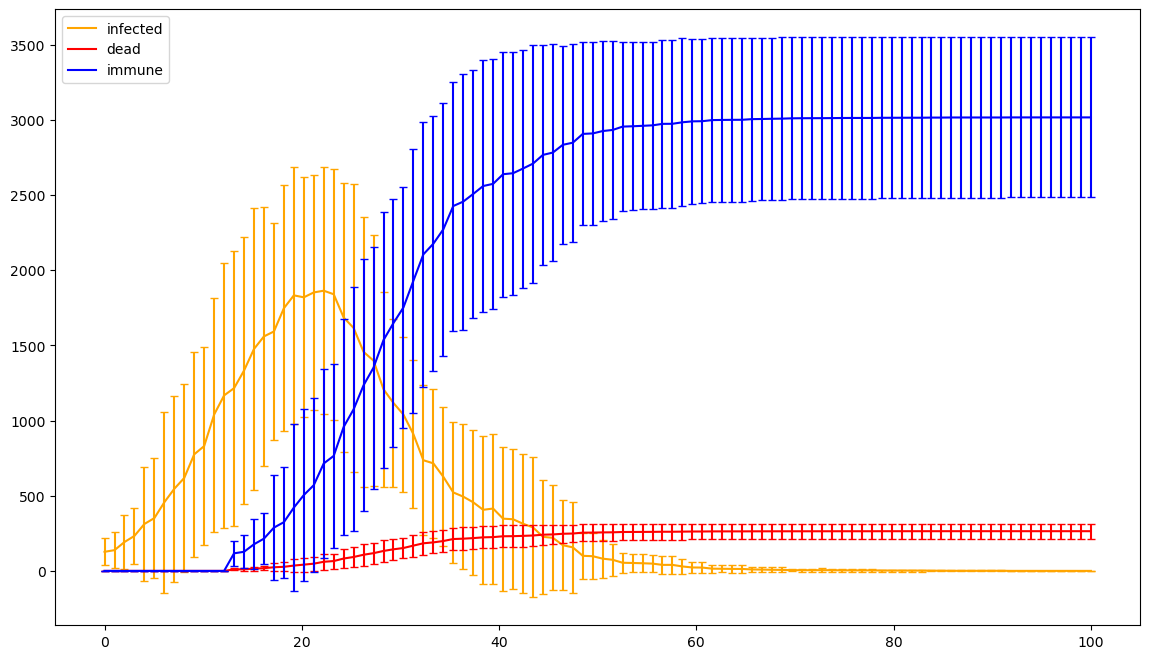

In [94]:
avg_and_plot(all_results_run3)

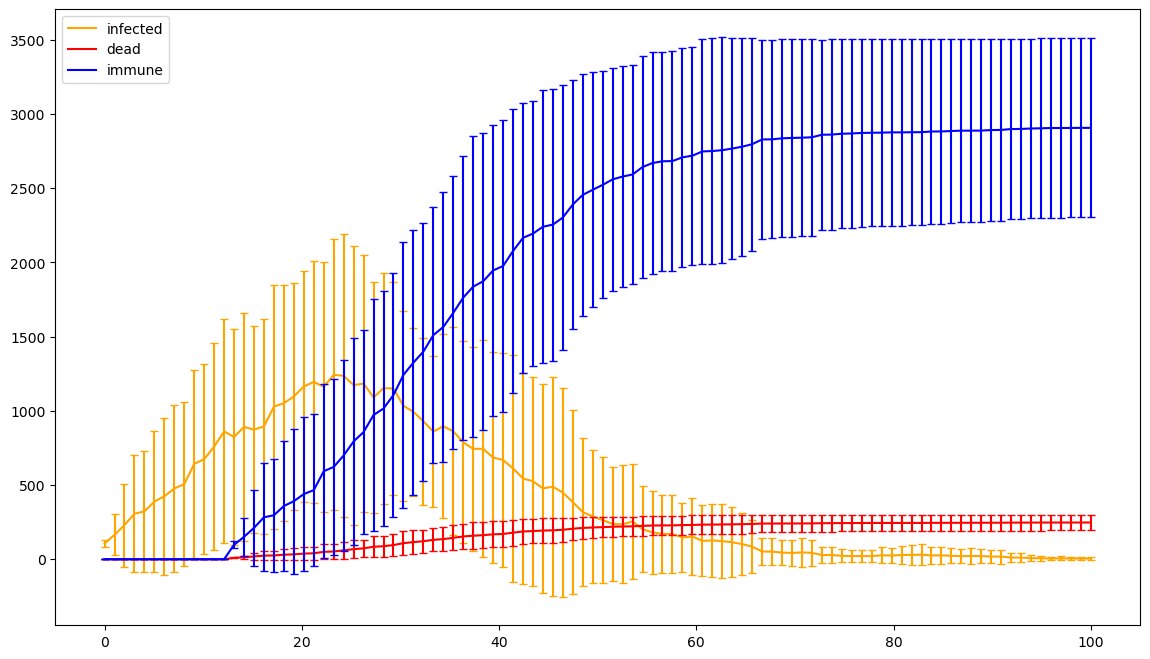

In [96]:
avg_and_plot(all_results_dc)

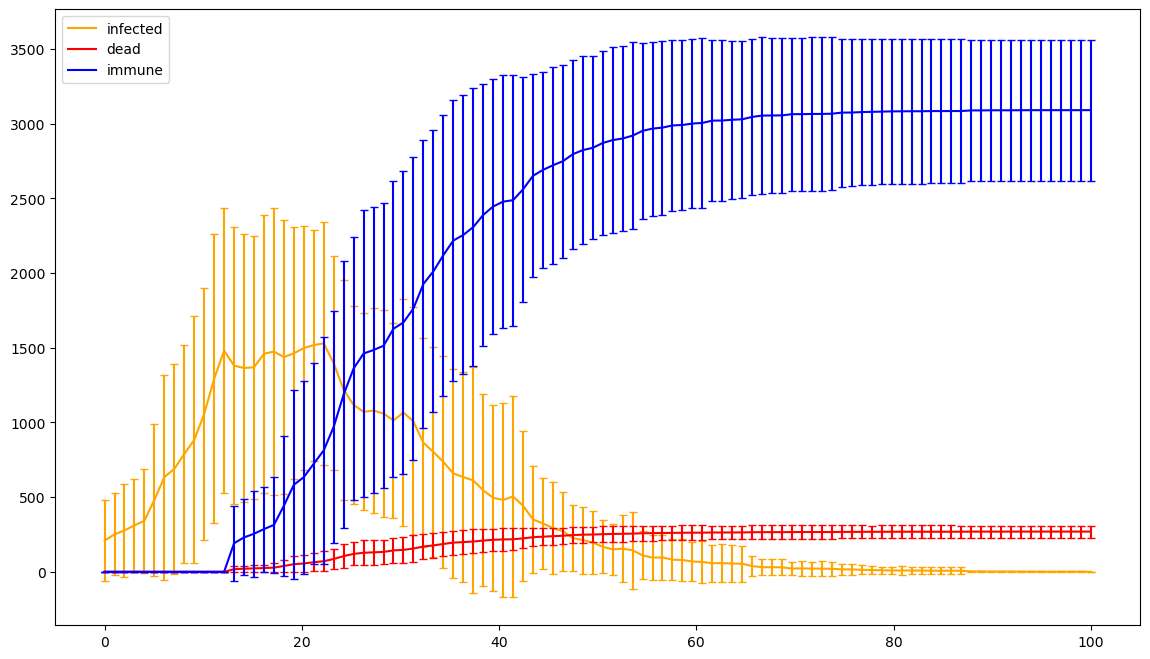

In [97]:
avg_and_plot(all_results_run1)

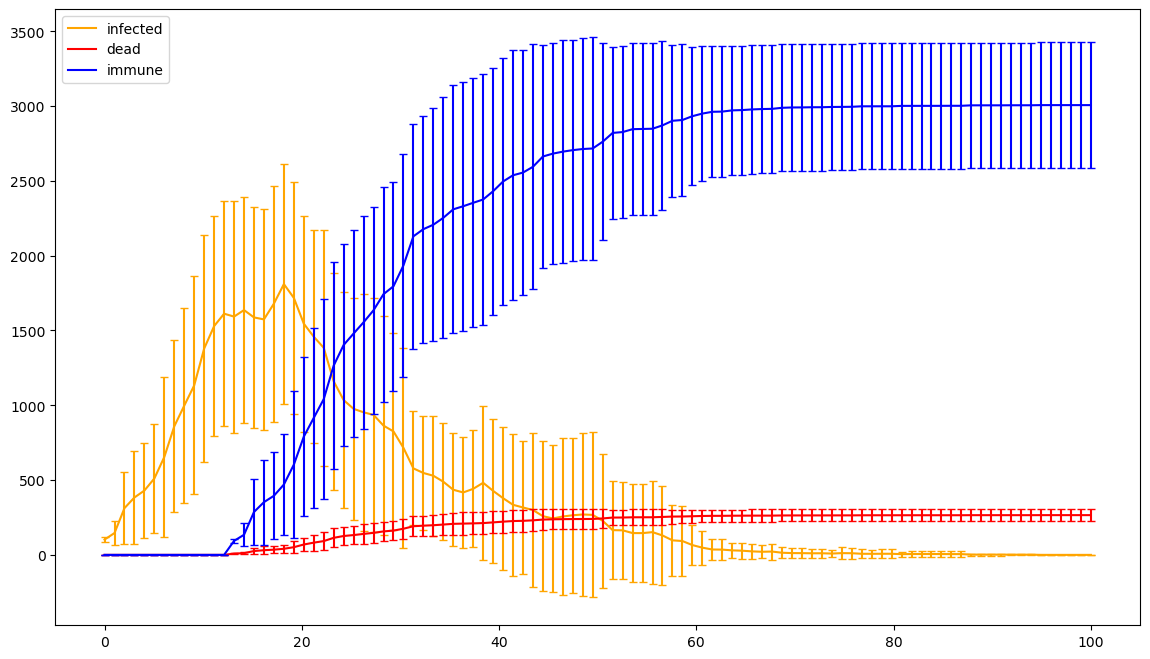

In [98]:
avg_and_plot(all_results_run2)